In [ ]:
def cv_score_kfold (estimator,X,y,Nsplits,count):
    cv=KFold(n_splits=Nsplits)
    mape_scorer = make_scorer(MAPE_function)

    MAE_cross = (-cross_val_score(estimator, X, y, cv=cv,scoring='neg_mean_absolute_error', n_jobs=1))
    RMSE_cross = (-cross_val_score(estimator, X, y, cv=cv, scoring='neg_root_mean_squared_error', n_jobs=1))
    R2_cross = 100*(cross_val_score(estimator, X, y, cv=cv, scoring='r2',n_jobs=1))
    MAPE_cross=(cross_val_score(estimator, X, y, cv=cv, scoring=mape_scorer,n_jobs=1))
    #y_pred = cross_val_predict(estimator, X, y, cv=cv, n_jobs=-1)
    
    cv_ΜΑΕ_means.insert(count,MAE_cross.mean())
    cv_RMSE_means.insert(count,RMSE_cross.mean())
    cv_R2_means.insert(count,R2_cross.mean())
    cv_MAPE_means.insert(count,MAPE_cross.mean())
    
    print(f"MAE: {MAE_cross.mean()} (+/- {MAE_cross.std()})")
    print(f"RMSE: {RMSE_cross.mean()} (+/- {RMSE_cross.std()})")
    print(f"R-squared: {R2_cross.mean()} (+/- {R2_cross.std()})")
    print(f"MAPE: {MAPE_cross.mean()} (+/- {MAPE_cross.std()})")
    return 


In [ ]:
def stacked_model(X_test,y_test):
    import time
    estimators= [ 
    ('LGBM', LGBMRegressor(
    max_depth=10,
    num_leaves=20,
    min_data_in_leaf=70,
    max_bin=90
     
    )),
    ('CATBoost', cb.CatBoostRegressor(
        iterations=1200,
        learning_rate=0.1,
        depth=6,
        l2_leaf_reg=0.6,
        verbose=0,
        loss_function='MAE'
    )),
    ('RF', RandomForestRegressor(
    ))]
        
    XGBoost_stored = load('filename.XGBoost_stored') 
    y_pred_XGB = XGBoost_stored.predict(X_test)

    MLP_stored = load('filename.MLP_stored') 
    y_pred_MLP = MLP_stored.predict(X_test)

    RF_stored = load('filename.RF_stored') 
    y_pred_RF = RF_stored.predict(X_test)

    LGBM_stored = load('filename.LGBM_stored') 
    y_pred_LGBM = LGBM_stored.predict(X_test)

    CATBoost_stored = load('filename.CATBoost_stored') 
    y_pred_CATB = CATBoost_stored.predict(X_test)

    LSTM_stored = tf.keras.models.load_model("LSTM_model")
    X_test_LSTM = X_sc.fit_transform(X_test)
    X_test_LSTM=X_test_LSTM.reshape((X_test_LSTM.shape[0], 1, X_test_LSTM.shape[1]))
    y_pred_LSTM = LSTM_stored.predict(X_test_LSTM)
    y_pred_LSTM = y_sc.inverse_transform(y_pred_LSTM)
        
    x_train_stack = np.column_stack((y_pred_XGB, y_pred_LGBM, y_pred_CATB, y_pred_RF,y_pred_LSTM,y_pred_MLP))

    start=time.time()
    vot_stack = VotingRegressor(estimators=estimators, n_jobs=-1, verbose=0)
    vot_stack.fit(x_train_stack, y_test)
    dump(vot_stack, 'filename.vot_stack_stored') 
    y_pred = vot_stack.predict(x_train_stack)
    end = time.time()
    metrics (y_test,y_pred,'Stacking & Voting Ensemble',7)
    cv_score(vot_stack,x_train_stack,y_test,5,6)
    
    from matplotlib.ticker import MaxNLocator, FixedFormatter
    x_formatter = FixedFormatter(["0","0", "8", "16", "24","32", "40", "48","56","64", "72", "72"])
    nticks = 10
 

    fig, ax = plt.subplots(1, 1, figsize=(50, 30))
    y_pred=pd.DataFrame(y_pred)
    y_pred.rename(columns = {0:'Hybrid Model forecast'}, inplace = True)
    y_test=pd.DataFrame(y_test)
    y_test.rename(columns = {0:'Actual Energy Load'}, inplace = True)
    y_test.reset_index(drop=True, inplace=True)
    #y_test[248:296].plot(ax=ax, label='Actual Energy Load', style='--',linewidth=6)
    y_test[248:321].plot(ax=ax, label='Actual Energy Load', style='--',linewidth=6)
    #y_pred[248:296].plot(ax=ax, label='Model Ensemble', style='.-',linewidth=5)
    y_pred[248:321].plot(ax=ax, label='Model Ensemble', style='.-',linewidth=5)

    plt.ylabel('Energy Consumption (kWh)',fontsize = 28)
    plt.xlabel('Hour',fontsize = 28, )
    plt.title('Energy Load Forecast',fontsize = 32)
    #plt.xticks(range(len(x)), x)
    #ax.set_xticks([0, 8, 16, 24,32, 40, 48])
    ax.xaxis.set_major_locator(MaxNLocator(nticks))
    ax.xaxis.set_major_formatter(x_formatter)
    ax.tick_params(axis='both', which='both', labelsize=26)
    plt.legend(prop = {'size' : 30})
    
    return()

In [ ]:
#Evaluation Metrics
def metrics (y_test,y_pred,model_name,count):
    print(f"Model:{model_name}")
    print("MAPE (%):",np.round(100*(mean_absolute_percentage_error(y_test, y_pred)),3))
    MAPE.insert(count,np.round(100*(mean_absolute_percentage_error(y_test, y_pred)),3))
    print("MAE (kWh):", np.round((mean_absolute_error(y_test, y_pred,)),3))
    MAE.insert(count,np.round((mean_absolute_error(y_test, y_pred,)),3))
    print("RMSE (kWh):",np.round(np.sqrt(mean_squared_error(y_test,y_pred)),3))  
    RMSE.insert(count,np.round(np.sqrt(mean_squared_error(y_test,y_pred)),3))                          
    print("R-squared (%):", np.round(100*r2_score(y_test,y_pred),3))
    R_squared.insert(count,np.round(100*r2_score(y_test,y_pred),3))
    print("ET(seconds):", np.round((end-start),3))
    ET.insert(count,np.round((end-start),3))
    return

In [ ]:
stacked_model(X_test,y_test)

: 

In [ ]:
#Evaluation Metrics
def metrics (y_test,y_pred,model_name,count):
    print(f"Model:{model_name}")
    print("MAPE (%):",np.round(100*(mean_absolute_percentage_error(y_test, y_pred)),3))
    MAPE.insert(count,np.round(100*(mean_absolute_percentage_error(y_test, y_pred)),3))
    print("MAE (kWh):", np.round((mean_absolute_error(y_test, y_pred,)),3))
    MAE.insert(count,np.round((mean_absolute_error(y_test, y_pred,)),3))
    print("RMSE (kWh):",np.round(np.sqrt(mean_squared_error(y_test,y_pred)),3))  
    RMSE.insert(count,np.round(np.sqrt(mean_squared_error(y_test,y_pred)),3))                          
    print("R-squared (%):", np.round(100*r2_score(y_test,y_pred),3))
    R_squared.insert(count,np.round(100*r2_score(y_test,y_pred),3))
    print("ET(seconds):", np.round((end-start),3))
    ET.insert(count,np.round((end-start),3))
    return

100/100 [==============================] - 0s 1ms/step


C:\Users\enik_\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_voting.py:600: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model:Stacking & Voting Ensemble
MAPE (%): 6.121
MAE (kWh): 0.147
RMSE (kWh): 0.303
R-squared (%): 97.248
ET(seconds): 7.592


C:\Users\enik_\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_voting.py:600: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\enik_\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_voting.py:600: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\enik_\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_voting.py:600: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\enik_\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_voting.py:600: DataConversionWarning: A column-vector y was passed when 

MAE: 0.3873931764933043 (+/- 0.10555791988858043)
RMSE: 0.6944095266631825 (+/- 0.21676644642646734)
R-squared: 80.07532646659132 (+/- 17.560671527159887)
MAPE: 64.1710686536828 (+/- 11.77008121584057)


C:\Users\enik_\AppData\Local\Temp\ipykernel_15124\393045391.py:76: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_major_formatter(x_formatter)


()

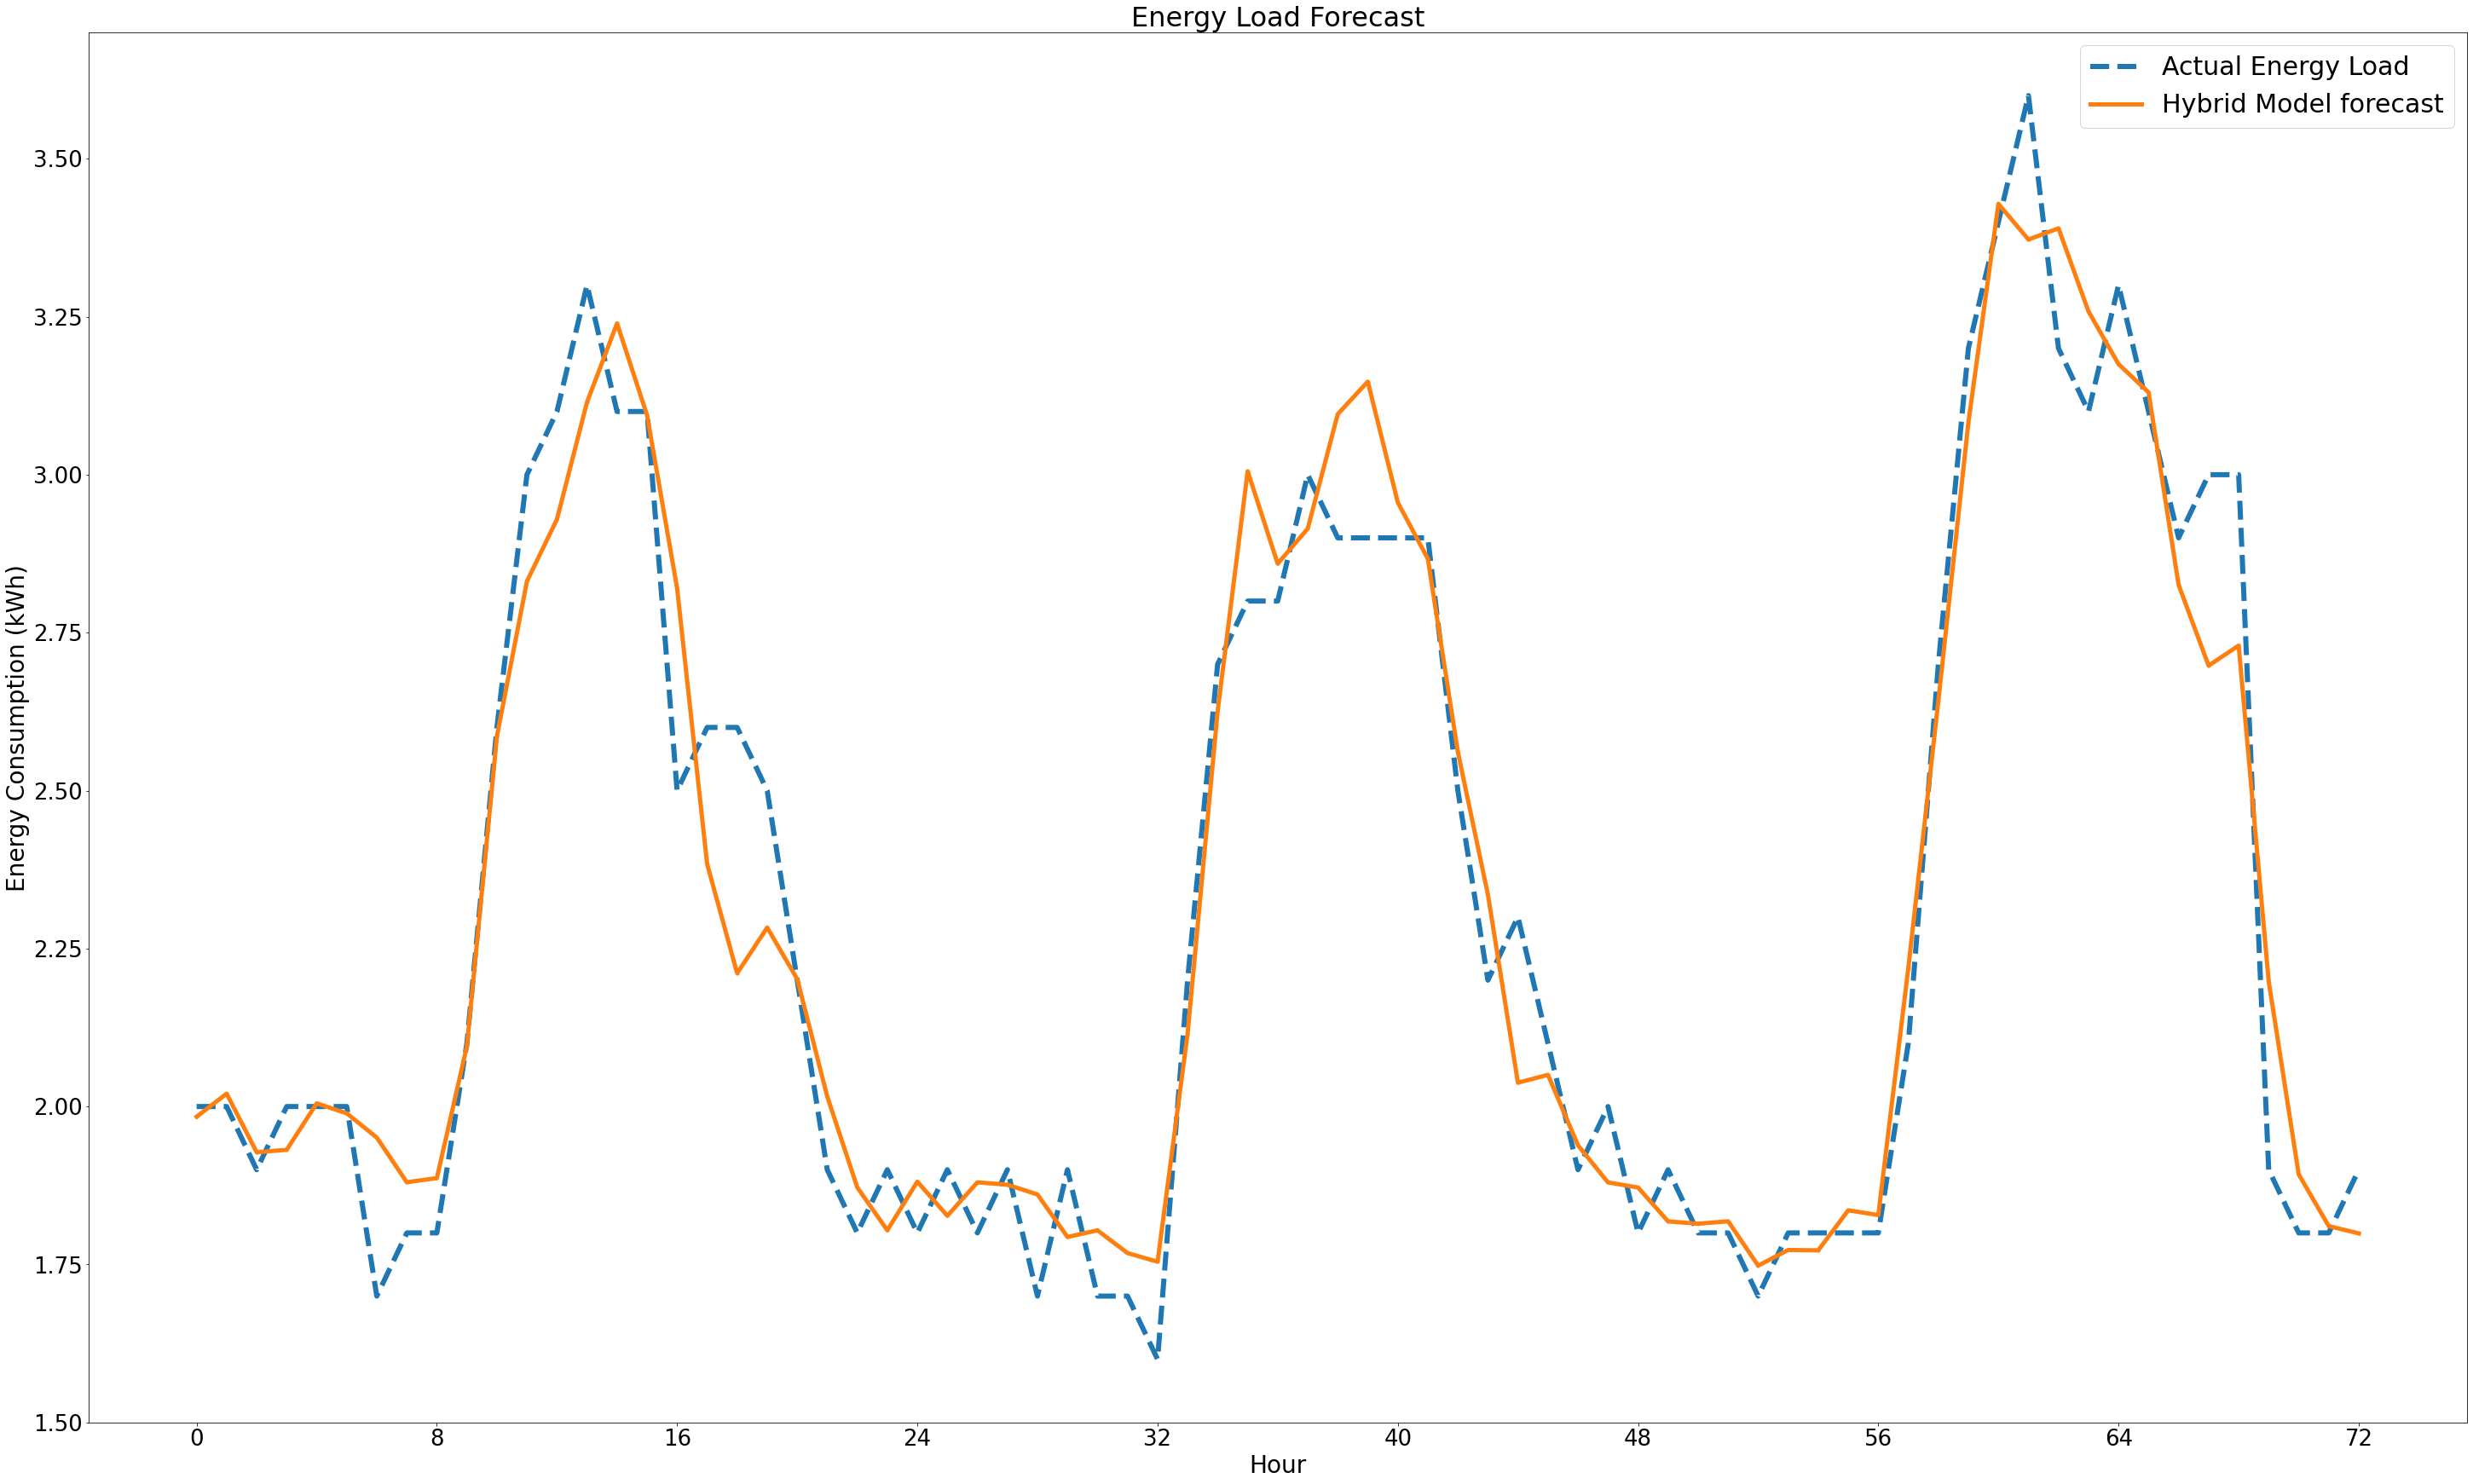

In [ ]:
stacked_model(X_test,y_test)

In [ ]:
df_genome = pd.read_csv("D:/Data Science MsC/IHU/MsC Thesis\My Notes\Other datasets/Bobcat_edu_test.csv")
#df_genome

df_genome[df_genome.isna().any(axis=1)]
df_genome=df_genome.dropna()
df_genome

,timestamp,Generation,Consumption,Temperature
0,1/1/2016 0:00,0.37,92.1202,-14.4
1,1/1/2016 1:00,0.39,87.0000,-13.3
2,1/1/2016 2:00,0.39,85.2501,-15.0
3,1/1/2016 3:00,0.38,83.7502,-12.8
4,1/1/2016 4:00,0.39,83.5001,-14.4
...,...,...,...,...
17520,12/31/2017 0:00,0.36,64.0000,-2.2
17521,12/31/2017 1:00,0.37,63.2500,-3.9
17522,12/31/2017 2:00,0.38,64.2500,-3.9
17523,12/31/2017 3:00,0.35,65.0000,-4.4


In [ ]:
from datetime import datetime
def convert_func(x):
    return datetime.strptime(x, "%m/%d/%Y %H:%M").strftime("%Y-%m-%d %H:%M:%S")

df_genome['timestamp'] = df_genome['timestamp'].astype(str)
df_genome['timestamp'] = df_genome['timestamp'].apply(convert_func)
df_genome['timestamp'] = pd.to_datetime(df_genome['timestamp'], errors='coerce')
df_genome.index=df_genome['timestamp'];df_genome


,timestamp,Generation,Consumption,Temperature
timestamp,,,,
2016-01-01 00:00:00,2016-01-01 00:00:00,0.37,92.1202,-14.4
2016-01-01 01:00:00,2016-01-01 01:00:00,0.39,87.0000,-13.3
2016-01-01 02:00:00,2016-01-01 02:00:00,0.39,85.2501,-15.0
2016-01-01 03:00:00,2016-01-01 03:00:00,0.38,83.7502,-12.8
2016-01-01 04:00:00,2016-01-01 04:00:00,0.39,83.5001,-14.4
...,...,...,...,...
2017-12-31 00:00:00,2017-12-31 00:00:00,0.36,64.0000,-2.2
2017-12-31 01:00:00,2017-12-31 01:00:00,0.37,63.2500,-3.9
2017-12-31 02:00:00,2017-12-31 02:00:00,0.38,64.2500,-3.9


In [ ]:
df_genome['Hour'] = np.arange(len(df_genome))
df_genome.isna().any(axis=1)
df_genome

,timestamp,Generation,Consumption,Temperature,Hour
timestamp,,,,,
2016-01-01 00:00:00,2016-01-01 00:00:00,0.37,92.1202,-14.4,0
2016-01-01 01:00:00,2016-01-01 01:00:00,0.39,87.0000,-13.3,1
2016-01-01 02:00:00,2016-01-01 02:00:00,0.39,85.2501,-15.0,2
2016-01-01 03:00:00,2016-01-01 03:00:00,0.38,83.7502,-12.8,3
2016-01-01 04:00:00,2016-01-01 04:00:00,0.39,83.5001,-14.4,4
...,...,...,...,...,...
2017-12-31 00:00:00,2017-12-31 00:00:00,0.36,64.0000,-2.2,15772
2017-12-31 01:00:00,2017-12-31 01:00:00,0.37,63.2500,-3.9,15773
2017-12-31 02:00:00,2017-12-31 02:00:00,0.38,64.2500,-3.9,15774


In [ ]:
df_genome['Consumption'].mean()

120.89778128921725

In [ ]:
df_temp=((df_genome['timestamp']) < ('2016-12-31 00:00:00'))
df_genome=df_genome.loc[df_temp]
df_genome

,timestamp,Generation,Consumption,Temperature,Hour
timestamp,,,,,
2016-01-01 00:00:00,2016-01-01 00:00:00,0.37,92.1202,-14.4,0
2016-01-01 01:00:00,2016-01-01 01:00:00,0.39,87.0000,-13.3,1
2016-01-01 02:00:00,2016-01-01 02:00:00,0.39,85.2501,-15.0,2
2016-01-01 03:00:00,2016-01-01 03:00:00,0.38,83.7502,-12.8,3
2016-01-01 04:00:00,2016-01-01 04:00:00,0.39,83.5001,-14.4,4
...,...,...,...,...,...
2016-12-30 19:00:00,2016-12-30 19:00:00,0.00,97.5000,-6.1,8178
2016-12-30 20:00:00,2016-12-30 20:00:00,0.00,99.5000,-6.1,8179
2016-12-30 21:00:00,2016-12-30 21:00:00,0.00,71.5000,-5.6,8180


In [ ]:
df_genome.describe().T

,count,mean,std,min,25%,50%,75%,max
Generation,8183.0,2.993474,4.745176,0.0,0.3500,0.3800,3.9350,16.20
Consumption,8183.0,125.059231,43.328167,0.0,80.0001,124.0001,161.5001,288.75
Temperature,8183.0,11.236221,11.088635,-16.7,2.2000,10.6000,19.4000,37.20
Hour,8183.0,4091.000000,2362.372960,0.0,2045.5000,4091.0000,6136.5000,8182.00


In [ ]:
df_cons_weh.describe().T

,count,mean,std,min,25%,50%,75%,max
Temperature_v1,15927.0,17.212629,8.423852,-3.900000,10.400,16.825000,23.87500,38.050000
Relative_Humidity_v1,15927.0,64.592730,15.966516,19.500000,52.500,64.500000,77.25000,100.000000
Wind_Speed_v1,15927.0,4.181051,3.126717,0.385661,2.412,3.600000,4.82400,36.444104
Clouds_v1,15927.0,43.154182,40.313795,0.000000,0.250,31.253731,90.00000,100.000000
Energy_Consumption,15927.0,2.664749,1.857291,0.000000,1.300,2.100000,3.50000,9.100000
Energy_Generation,15927.0,1.617862,2.520233,0.000000,0.000,0.005500,2.61775,9.536250
Hour,15927.0,7963.000000,4597.873204,0.000000,3981.500,7963.000000,11944.50000,15926.000000


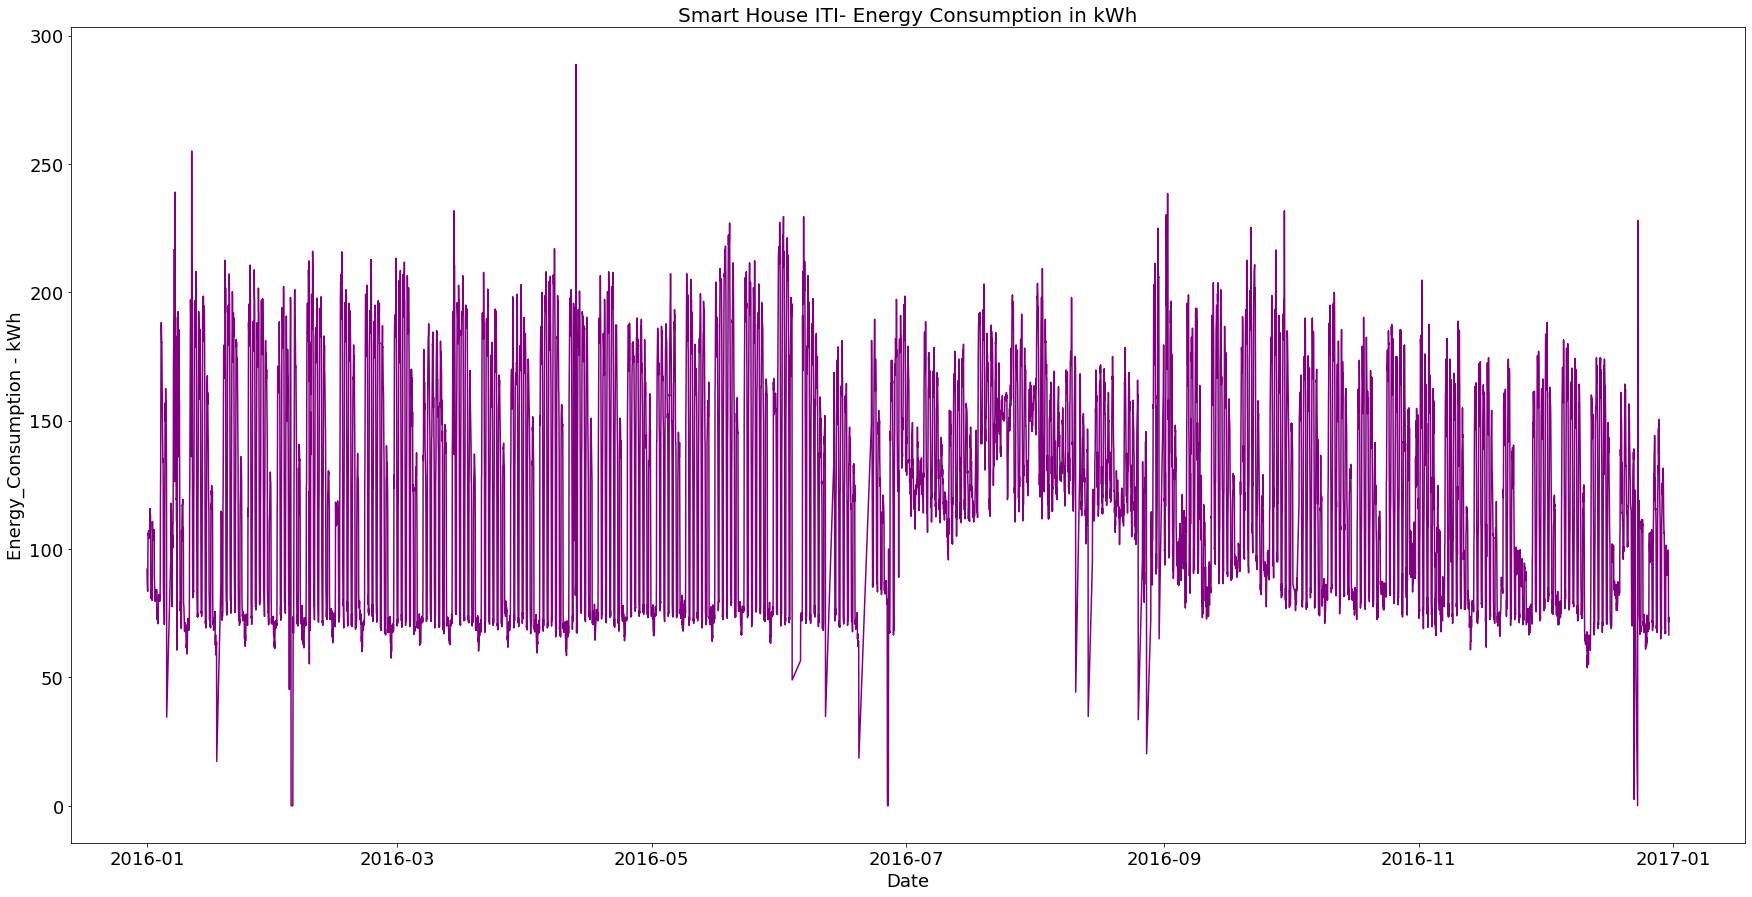

In [ ]:
fig, ax = plt.subplots(figsize=(30, 15))
# Add x-axis and y-axis
ax.plot(df_genome['timestamp'],
       df_genome['Consumption'],
       color='purple')
# Set title and labels for axes
ax.set_title("Smart House ITI- Energy Consumption in kWh", fontsize = 20)
ax.set_xlabel('Date', fontsize = 18)
ax.set_ylabel('Energy_Consumption - kWh', fontsize = 18)
ax.tick_params(axis='both', which='major', labelsize=18)
plt.show()

In [ ]:
UpperOutlierPerc=99.98
upper_cons = np.percentile(df_genome['Consumption'], UpperOutlierPerc); upper_cons
df_genome['Consumption'] = df_genome['Consumption'].apply(lambda x : upper_cons if x > upper_cons else x)
df_genome=df_genome[df_genome['Consumption']>40]

C:\Users\enik_\AppData\Local\Temp\ipykernel_15124\1554646107.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_genome['Consumption'] = df_genome['Consumption'].apply(lambda x : upper_cons if x > upper_cons else x)


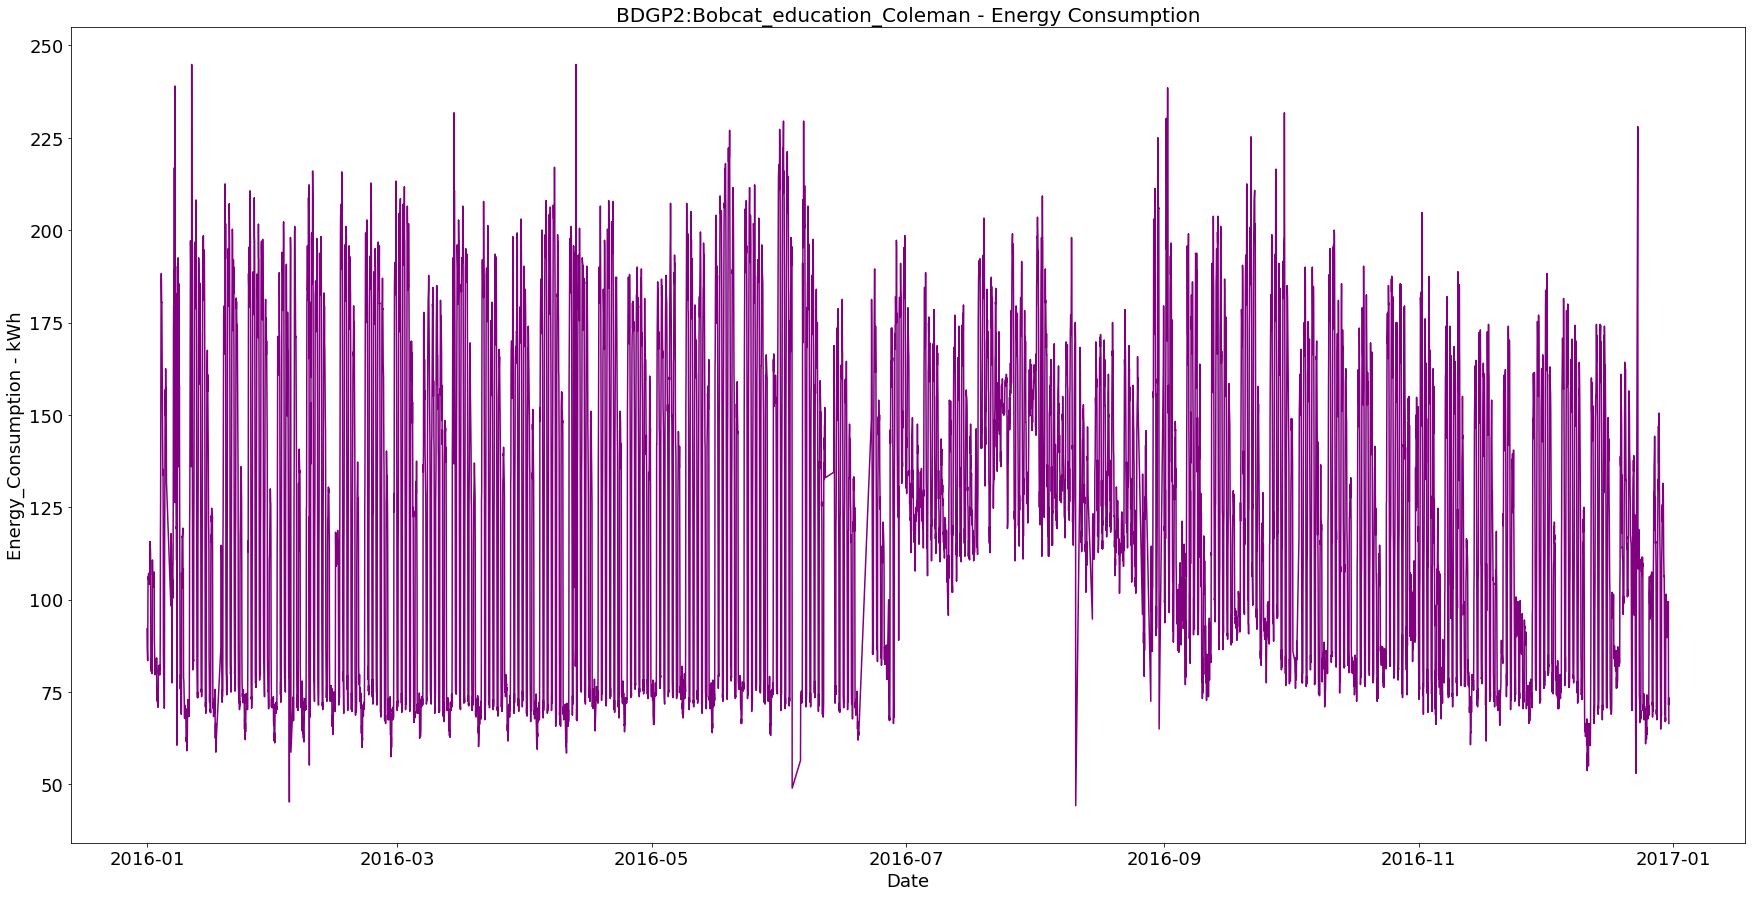

In [ ]:
fig, ax = plt.subplots(figsize=(30, 15))
# Add x-axis and y-axis
ax.plot(df_genome['timestamp'],
       df_genome['Consumption'],
       color='purple')
# Set title and labels for axes
ax.set_title("BDGP2:Bobcat_education_Coleman - Energy Consumption", fontsize = 20)
ax.set_xlabel('Date', fontsize = 18)
ax.set_ylabel('Energy_Consumption - kWh', fontsize = 18)
ax.tick_params(axis='both', which='major', labelsize=18)
plt.show()

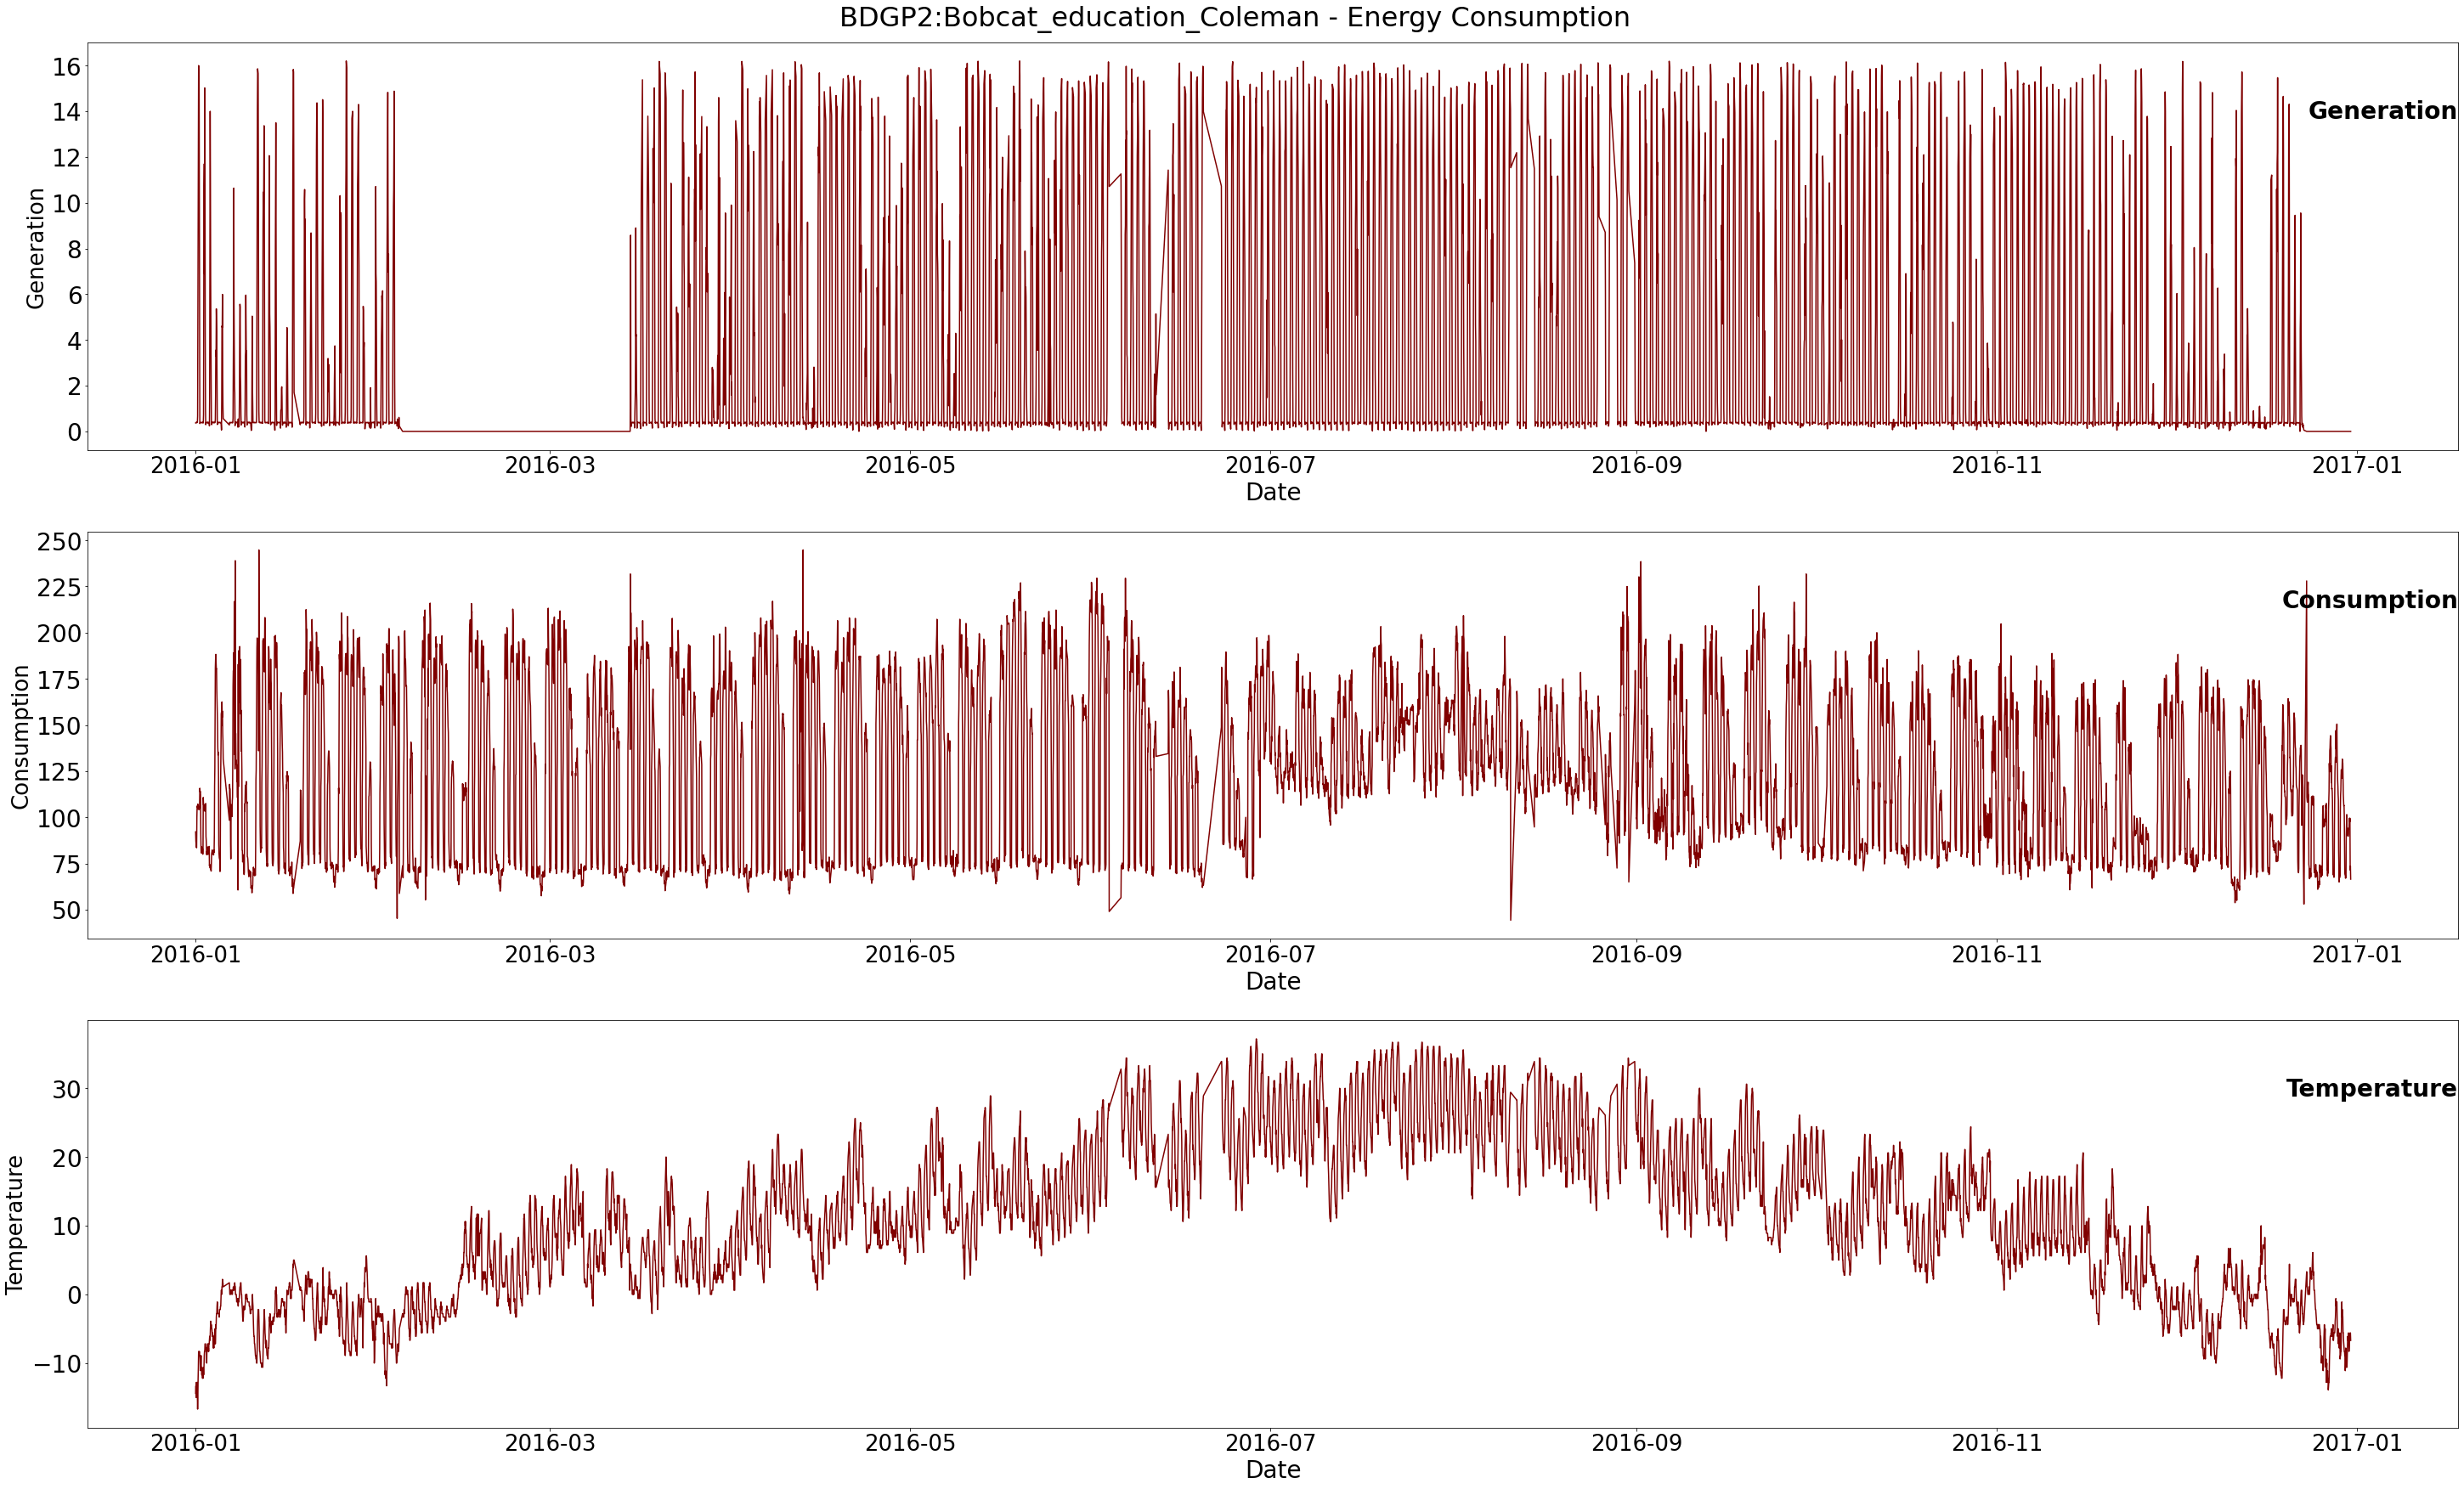

In [ ]:
# plot target and each feature
groups = [1, 2, 3]
i = 1
plt.figure(figsize = (50, 30))
for group in groups:
    plt.suptitle('BDGP2:Bobcat_education_Coleman - Energy Consumption', fontsize=32,y=0.9)
    plt.subplot(len(groups), 1, i)
    plt.plot(df_genome['timestamp'],df_genome.values[:, group], color='maroon')
    plt.title(df_genome.columns[group], y=0.8, loc='right',fontsize=28,fontweight='bold')
    plt.xlabel('Date', fontsize=28)
    plt.ylabel(df_genome.columns[group],fontsize=26)
    plt.xticks(fontsize=26)
    plt.yticks(fontsize=28)
    i += 1
plt.show()

In [ ]:
#Creating time-related features
quarter=df_genome.timestamp.dt.quarter
months = df_genome.timestamp.dt.month
day_of_months = df_genome.timestamp.dt.day
hours = df_genome.timestamp.dt.hour
minutes = df_genome.timestamp.dt.minute
to_one_hot = df_genome.timestamp.dt.day_name()
week_days= df_genome.timestamp.dt.weekday
is_weekend = to_one_hot.apply(lambda x : 1 if x in ['Saturday','Sunday'] else 0)
#Define work hours & off-hours
working_hours=((hours <= 18) & (hours >= 9)).apply(lambda x : 1 if x==True else 0)
off_hours=((hours > 18) | (hours < 9)).apply(lambda x : 1 if x==True else 0)

timestamp_features_new = pd.DataFrame({
    'quarter': quarter,
    'month' : months,
    'day_of_month' : day_of_months,
    'hour24' : hours,
    'is_weekend' : is_weekend,
    'working_hours': working_hours,
    'off_hours': off_hours,
    'Week_day':week_days
})
timestamp_features_new

,quarter,month,day_of_month,hour24,is_weekend,working_hours,off_hours,Week_day
timestamp,,,,,,,,
2016-01-01 00:00:00,1,1,1,0,0,0,1,4
2016-01-01 01:00:00,1,1,1,1,0,0,1,4
2016-01-01 02:00:00,1,1,1,2,0,0,1,4
2016-01-01 03:00:00,1,1,1,3,0,0,1,4
2016-01-01 04:00:00,1,1,1,4,0,0,1,4
...,...,...,...,...,...,...,...,...
2016-12-30 19:00:00,4,12,30,19,0,0,1,4
2016-12-30 20:00:00,4,12,30,20,0,0,1,4
2016-12-30 21:00:00,4,12,30,21,0,0,1,4


In [ ]:
from tsextract.feature_extraction.extract import build_features, build_features_forecast
features_request = {
    "window": [24],
}
Cons_sliding = build_features(df_genome['Consumption'], features_request, target_lag=1, include_tzero=True)

features_request = {
    "window": [12],
    
}
Temp_sliding  = build_features(df_genome['Temperature'], features_request, target_lag=1, include_tzero=True)
Gen_sliding = build_features(df_genome['Generation'], features_request, target_lag=1, include_tzero=True)

Cons_sliding.rename(columns = {'tzero':'Consumption'}, inplace = True)
Cons_sliding

Cons_sliding.drop("Target_Tplus1",axis = 1, inplace = True)
#Cons_sliding.drop("tzero",axis = 1, inplace = True)
Cons_sliding = Cons_sliding.add_suffix('Cons')
Gen_sliding.drop("Target_Tplus1",axis = 1, inplace = True)
Gen_sliding.drop("tzero",axis = 1, inplace = True)
Gen_sliding = Gen_sliding.add_suffix('Gen')
Temp_sliding.drop("Target_Tplus1",axis = 1, inplace = True)
Temp_sliding = Temp_sliding.add_suffix('Temp')

#Extra features from statistics

features_request = {
    "window": [72],
}
Cons72_temp = build_features(df_genome['Consumption'], features_request, target_lag=1, include_tzero=True)

Cons48 = Cons72_temp.loc[:,['T-48']]
Cons48.rename(columns={'T-48':'T-48Cons'}, inplace = True)
Cons72 = Cons72_temp.loc[:,['T-72']]
Cons72.rename(columns={'T-72':'T-72Cons'}, inplace = True)

std24_cons=pd.Series(abs((Cons72_temp['T-1']+Cons72_temp['T-24'])/2 - Cons72_temp['T-1']), name='std24_cons')

features_lag_new=pd.concat(
    [Cons_sliding,
     Gen_sliding, 
     Temp_sliding,
     Cons48,
     Cons72,
     std24_cons
    ],axis = 1)
features_lag_new

features_new=pd.concat(
    [
    features_lag_new,
    timestamp_features_new,
    
    ],
    axis = 1)
features_new
features_new=features_new.dropna()
features_new.index.name='new_Timestamp_UTC'


In [ ]:
y_test_newdata=features_new['ConsumptionCons']
features_new.drop('ConsumptionCons',axis = 1, inplace = True)
X_test_newdata=features_new

In [ ]:
y_test_newdata=pd.DataFrame(y_test_newdata)
y_test_newdata.rename(columns = {'ConsumptionCons':'Actual Energy Load'}, inplace = True)

253/253 [==============================] - 1s 1ms/step


C:\Users\enik_\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_voting.py:600: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model:Stacking & Voting Ensemble
MAPE (%): 5.879
MAE (kWh): 6.885
RMSE (kWh): 10.768
R-squared (%): 93.694
ET(seconds): 17.232


C:\Users\enik_\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_voting.py:600: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\enik_\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_voting.py:600: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\enik_\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_voting.py:600: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\enik_\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_voting.py:600: DataConversionWarning: A column-vector y was passed when 

MAE: 12.554887037034751 (+/- 1.4015522982842668)
RMSE: 17.75969261823116 (+/- 2.7448151912279064)
R-squared: 77.98816560260381 (+/- 6.83300008566013)
MAPE: 38.48914366462629 (+/- 8.963881310962442)


C:\Users\enik_\AppData\Local\Temp\ipykernel_15124\1029433026.py:76: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_major_formatter(x_formatter)


()

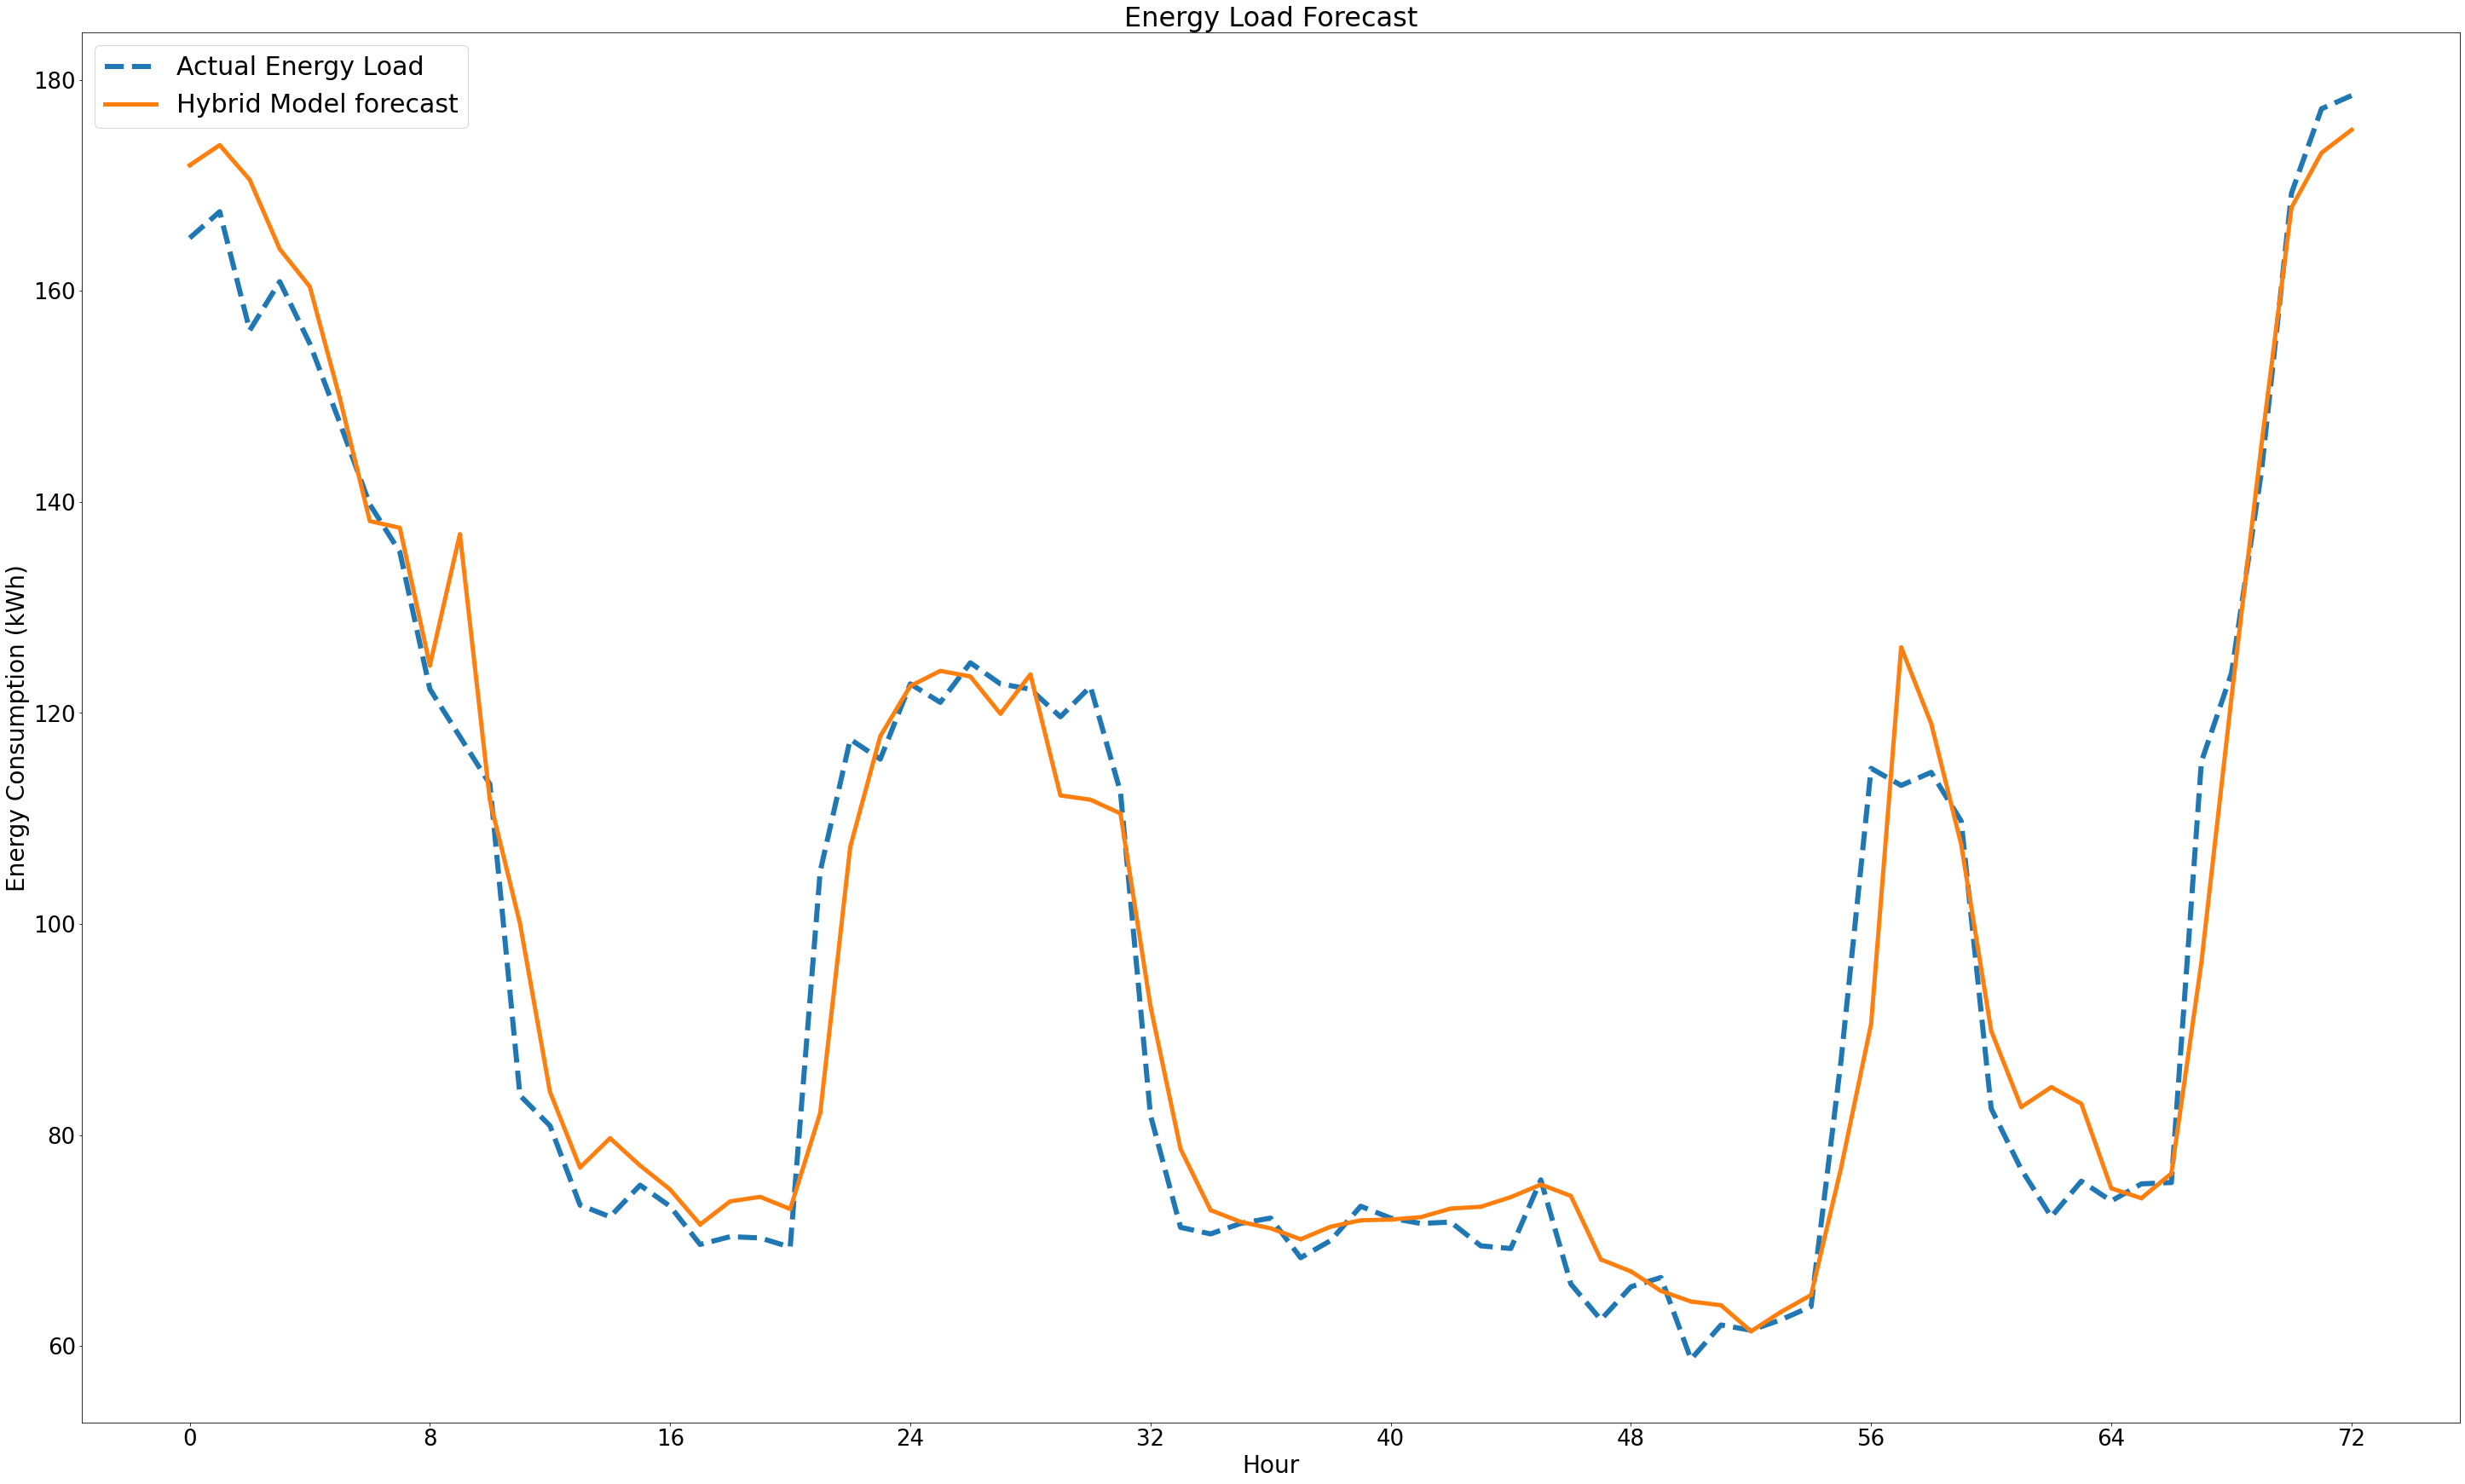

In [ ]:
stacked_model(X_test_newdata,y_test_newdata)